In [1]:
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import pandas as pd
import rasterio
import matplotlib.pyplot as plt

In [6]:
crta_coords = pd.read_csv('calculate_aoo/df2csv/cornuta_all.csv')
crta_coords = crta_coords[(crta_coords['lat']>0) & (crta_coords['long']>-20)]
print(f'lat_min = {crta_coords['lat'].min()}\nlat_max = {crta_coords['lat'].max()}\nlon_min = {crta_coords['long'].min()}\nlat_max = {crta_coords['long'].max()}\n')

lat_min = 34.9625
lat_max = 59.918117
lon_min = -7.537369
lat_max = 51.08368



In [49]:
bbox = [-8, 35, 52, 60] #minx, miny, maxx, maxy

num_points_side = int(np.sqrt(5000))  
lons = np.linspace(bbox[0], bbox[2], num_points_side)
lats = np.linspace(bbox[1], bbox[3], num_points_side)

grid_points = [Point(lon, lat) for lat in lats for lon in lons]
grid_gdf = gpd.GeoDataFrame(geometry=grid_points)

shapefile_path = 'data/shapefiles/ne_110m_land/ne_110m_land.shp'
gdf = gpd.read_file(shapefile_path)

lakes_shapefile_path = 'data/shapefiles/ne_110m_lakes/ne_110m_lakes.shp'
lakes_gdf = gpd.read_file(lakes_shapefile_path)

land_points = grid_gdf[grid_gdf['geometry'].apply(lambda point:gdf.contains(point).any() and not lakes_gdf.contains(point).any())]
land_coordinates = [(point.y, point.x) for point in land_points['geometry']]

lakes = cfeature.NaturalEarthFeature(category='physical', name='lakes', scale='110m')

(-10.99999999999996, 52.9999999999998, 33.99999999999987, 69.03428709808546)

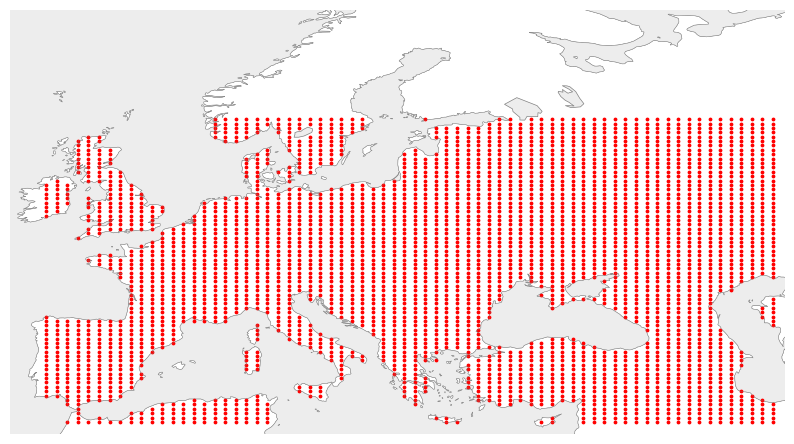

In [53]:

plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax = plt.gca()
ax.set_extent([-11, 53, 34,  66])  # Set the extent (longitude, longitude, latitude, latitude)


ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='gray', linewidth=.5)
ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')
ax.add_feature(lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')

#ndvi_tiff_path = '/home/mpgetz/repos/bee_mapping/data/wc2.1_30s_bio/NDVI_hires.tif'
#with rasterio.open(ndvi_tiff_path) as ndvi_src:
#   ndvi_data = ndvi_src.read(1)
#    vmin, vmax = ndvi_data.min(), ndvi_data.max()

#    plt.imshow(ndvi_data, vmin=-1, vmax=1, origin='upper', transform=ccrs.PlateCarree(), cmap='twilight_shifted')

lats, lons = zip(*land_coordinates)
ax.scatter(lons, lats, transform=ccrs.PlateCarree(), marker='o', color='red', s=3)
ax.axis('off')

# cbar = plt.colorbar(label='NDVI', fraction=0.03, pad=0.04)
# cbar.set_label('NDVI') , extent=[-127, -64.5, 34, 55]

In [55]:
europe_df = pd.DataFrame(land_coordinates, columns=['lat', 'lon'])

In [ ]:
import os
from concurrent.futures import ThreadPoolExecutor


def get_value_from_array(lat, long, src, array):
    try:
        row, col = src.index(long, lat)
        return array[row, col]
    except Exception as e:
        print(f'Error at {lat}, {long}: {e}')
        return None
    
ndvi_tiff_path = '/home/mpgetz/repos/bee_mapping/data/tifs/namerica_NDVI.tif'
all_files = [ndvi_tiff_path]

print(all_files)

def process_file(file):
    column_name = 'ndvi'
    print(f'Processing: {column_name}\n')

    with rasterio.open(file) as src:
        array = src.read(1)  # Read the entire file into an array
        europe_df[column_name] = europe_df.apply(lambda row: get_value_from_array(row['lat'], row['lon'], src, array), axis=1)

with ThreadPoolExecutor(max_workers=1) as executor: 
    executor.map(process_file, all_files)

directory = '/home/mpgetz/repos/bee_mapping/data/wc2.1_30s_bio'
all_files = [f for f in os.listdir(directory) if f.endswith('.tif') and "wc2.1_30s_" in f]

print(all_files)

def process_file(file):
    column_name = file.split("wc2.1_30s_")[1].replace(".tif", "")
    file_path = os.path.join(directory, file)
    print(f'Processing: {column_name}\n')

    with rasterio.open(file_path) as src:
        array = src.read(1)  
        europe_df[column_name] = europe_df.apply(lambda row: get_value_from_array(row['lat'], row['lon'], src, array), axis=1)

with ThreadPoolExecutor(max_workers=4) as executor:  
    executor.map(process_file, all_files)

america_df.to_csv('america_bioclim_ndvi.csv')
